Загрузка библиотек

In [89]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

import warnings
warnings.filterwarnings('ignore')

Загрузка данных

In [90]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.set_index('Id', inplace=True)
test_df.set_index('Id', inplace=True)

train_df.shape, test_df.shape

((10000, 19), (5000, 18))

In [91]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Сокращаем потребляемую память

In [92]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.54 MB
Decreased by 64.4%


In [93]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.24 MB
Decreased by 66.4%


In [94]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  int16   
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     7887 non-null   float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  int8    
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   5202 non-null   float32 
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-nul

#### Обработка пропусков

In [95]:
train_df.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Находим соотношение медиан жилой площади к общей площади

In [96]:
median_ls_train = (train_df['LifeSquare']).median() / (train_df['Square']).median()
median_ls_test = (test_df['LifeSquare']).median() / (test_df['Square']).median()
median_ls_train, median_ls_test

(0.6242467246775019, 0.6221514116761379)

Заполняем пропуски в LifeSquare значением df['Square'] * median_ls

In [97]:
train_df['LifeSquare'].fillna(train_df['Square'] * median_ls_train, inplace=True)
test_df['LifeSquare'].fillna(test_df['Square'] * median_ls_test, inplace=True)

Находим моду для Healthcare_1

In [98]:
mode_hc1_train = train_df['Healthcare_1'].mode()[0]
mode_hc1_test = test_df['Healthcare_1'].mode()[0]
mode_hc1_train, mode_hc1_test

(540.0, 540.0)

Заполняем пропуски в Healthcare_1 значением mode_hc1

In [99]:
train_df['Healthcare_1'].fillna(mode_hc1_train, inplace=True)
test_df['Healthcare_1'].fillna(mode_hc1_test, inplace=True)

In [100]:
train_df.isna().sum()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [101]:
test_df.isna().sum()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

In [102]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  int16   
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     10000 non-null  float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  int8    
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   10000 non-null  float32 
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-nul

#### Обработка категориальных признаков

In [103]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

train_df[feature_bin_names] = train_df[feature_bin_names].replace({'A':0, 'B':1})
test_df[feature_bin_names] = test_df[feature_bin_names].replace({'A':0, 'B':1})

In [104]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int16  
 1   Rooms          10000 non-null  float32
 2   Square         10000 non-null  float32
 3   LifeSquare     10000 non-null  float32
 4   KitchenSquare  10000 non-null  float32
 5   Floor          10000 non-null  int8   
 6   HouseFloor     10000 non-null  float32
 7   HouseYear      10000 non-null  int32  
 8   Ecology_1      10000 non-null  float32
 9   Ecology_2      10000 non-null  int64  
 10  Ecology_3      10000 non-null  int64  
 11  Social_1       10000 non-null  int8   
 12  Social_2       10000 non-null  int16  
 13  Social_3       10000 non-null  int16  
 14  Healthcare_1   10000 non-null  float32
 15  Helthcare_2    10000 non-null  int8   
 16  Shops_1        10000 non-null  int8   
 17  Shops_2        10000 non-null  int64  
 18  Pri

#### Анализ признаков и очистка данных

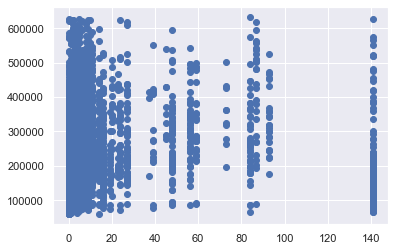

In [105]:
plt.scatter(train_df['Social_3'], train_df['Price']);

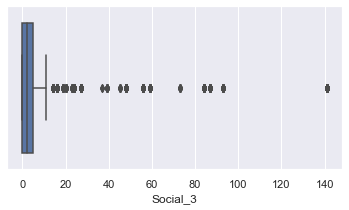

In [106]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Social_3'], whis=1.5)

plt.xlabel('Social_3')
plt.show()

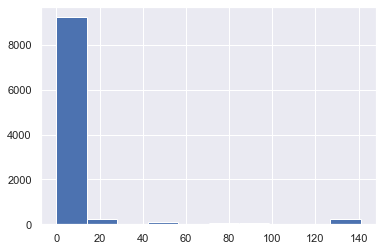

In [107]:
train_df['Social_3'].hist();

Заполняем медианой отклонения по Social_3

In [108]:
train_df.loc[train_df['Social_3'] > 10, 'Social_3'] = train_df['Social_3'].median()
test_df.loc[test_df['Social_3'] > 10, 'Social_3'] = test_df['Social_3'].median()

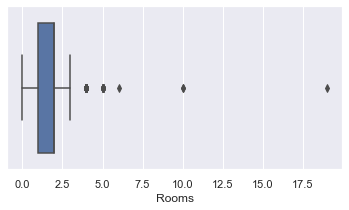

In [109]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Rooms'], whis=1.5)

plt.xlabel('Rooms')
plt.show()

Удаляем из выборки квартиры с более, чем 5 комнатами (их всего 4)

In [110]:
train_df.loc[(train_df['Rooms'] > 5), 'Rooms'] = train_df['Rooms'].mode()[0]
test_df.loc[(test_df['Rooms'] > 5), 'Rooms'] = train_df['Rooms'].mode()[0]

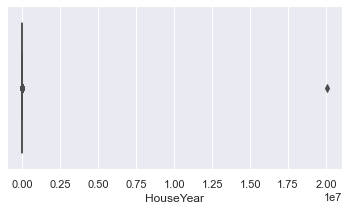

In [111]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['HouseYear'], whis=1.5)

plt.xlabel('HouseYear')
plt.show()

Заполняем медианами отклонения до 1935 года постройки

In [112]:
train_df.loc[train_df['HouseYear'] < 1935, 'HouseYear'] = int(train_df['HouseYear'].median())
test_df.loc[test_df['HouseYear'] < 1935, 'HouseYear'] = int(test_df['HouseYear'].median())

Убираем отклонения более 2020 года постройки

In [113]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

##### Очищаем данные по площадям общей, жилой и кухни

In [114]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,10000.000000,10000.000000
mean,56.315712,37.300068,6.273300
std,21.058718,76.868866,28.561113
min,1.136859,0.370619,0.000000
25%,41.774879,24.352570,1.000000
50%,52.513309,33.290489,6.000000
75%,65.900627,44.933548,9.000000
max,641.065186,7480.592285,2014.000000


Находим соотношение медиан кухни и общей площади

In [115]:
median_k_sq_train = train_df['KitchenSquare'].median() / train_df['Square'].median()
median_k_sq_test = test_df['KitchenSquare'].median() / test_df['Square'].median()
median_k_sq_train, median_k_sq_test

(0.11425674861392691, 0.11337581197219465)

Находим соотношение медиан общей площади и жилой

In [116]:
median_sq_ls_train = train_df['Square'].median() / train_df['LifeSquare'].median()
median_sq_ls_test = test_df['Square'].median() / test_df['LifeSquare'].median()
median_sq_ls_train, median_sq_ls_test

(1.5774267890254754, 1.5789935424421442)

и обратную

In [117]:
median_ls_sq_train = train_df['LifeSquare'].median() / train_df['Square'].median()
median_ls_sq_test = test_df['LifeSquare'].median() / test_df['Square'].median()
median_ls_sq_train, median_ls_sq_test

(0.6339438425651398, 0.6333148129620302)

Заполняем значениями df['Square'] * median_k_sq размер кухонь больше общей площади

In [118]:
train_df.loc[train_df['KitchenSquare'] > train_df['Square'], 'KitchenSquare'] = train_df['Square'] * median_k_sq_train
test_df.loc[test_df['KitchenSquare'] > test_df['Square'], 'KitchenSquare'] = test_df['Square'] * median_k_sq_test

Заполняем значениями df['Square'] * mediad_ls_sq размеры жилой площади, если они меньше кухни

In [119]:
train_df.loc[train_df['KitchenSquare'] > train_df['LifeSquare'], 'LifeSquare'] = train_df['Square'] * median_ls_sq_train
test_df.loc[test_df['KitchenSquare'] > test_df['LifeSquare'], 'LifeSquare'] = test_df['Square'] * median_ls_sq_test

Заполняем значениями df['Square'] * median_k_sq размер кухонь больше жилой площади

In [120]:
train_df.loc[train_df['KitchenSquare'] > train_df['LifeSquare'], 'KitchenSquare'] = train_df['Square'] * median_k_sq_train
test_df.loc[test_df['KitchenSquare'] > test_df['LifeSquare'], 'KitchenSquare'] = test_df['Square'] * median_k_sq_test

Заполняем размеры кухонь df['Square'] * median_k_sq, если их соотношение к общей площади в 3.5 раза больше median_k_sq

In [121]:
train_df.loc[train_df['KitchenSquare'] / train_df['Square'] > (median_k_sq_train * 3.5), 'KitchenSquare'] = train_df['Square'] * median_k_sq_train
test_df.loc[test_df['KitchenSquare'] / test_df['Square'] > (median_k_sq_test * 3.5), 'KitchenSquare'] = test_df['Square'] * median_k_sq_test

Удаляем из обучающего датафрейма строки с явно противоречивыми данными по соотношению площадей

In [122]:
train_df = train_df.drop(train_df[(train_df['LifeSquare'] < 10) & (train_df['Square'] < 10) & (train_df['Square'] < train_df['LifeSquare'])].index)
train_df.loc[(train_df['LifeSquare'] < 10) & (train_df['Square'] < 10) & (train_df['Square'] < train_df['LifeSquare'])]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,


Аналогично

In [123]:
train_df = train_df.drop(train_df[(train_df['LifeSquare'] > train_df['Square']) & (train_df['LifeSquare'] /  train_df['Square'] > 1.5)].index)
train_df.loc[(train_df['LifeSquare'] > train_df['Square']) & (train_df['LifeSquare'] / train_df['Square'] > 1.5)]
# test_df.loc[(test_df['LifeSquare'] > test_df['Square']) & (test_df['LifeSquare'] / test_df['Square'] > 1.5)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,


Заполняем значениями df['Square'] * mediad_ls_sq размеры жилых площадей больших общих

In [124]:
train_df.loc[train_df['LifeSquare'] > train_df['Square'], 'LifeSquare'] = train_df['Square'] * median_ls_sq_train
test_df.loc[test_df['LifeSquare'] > test_df['Square'], 'LifeSquare'] = test_df['Square'] * median_ls_sq_test

Заплняем значениями df['Square'] * mediad_ls_sq размеры жилых площадей, которые меньше 25% от общей площади

In [125]:
train_df.loc[train_df['LifeSquare'] < train_df['Square'] * 0.25, 'LifeSquare'] = train_df['Square'] * median_ls_sq_train
test_df.loc[test_df['LifeSquare'] < test_df['Square'] * 0.25, 'LifeSquare'] = test_df['Square'] * median_ls_sq_test

Заполняем значениями df['Square'] * median_k_sq площади кухонь < 0

In [126]:
train_df.loc[train_df['KitchenSquare'] == 0, 'KitchenSquare'] = train_df['Square'] * median_k_sq_train
test_df.loc[test_df['KitchenSquare'] == 0, 'KitchenSquare'] = test_df['Square'] * median_k_sq_test

В обоих датасетах cлишком много квартир с размером кухни 1 м^2, вероятно это ошибки и/или просто указана ненулевая площадь из-за отсутствия реальных данных. Попробуем исправить

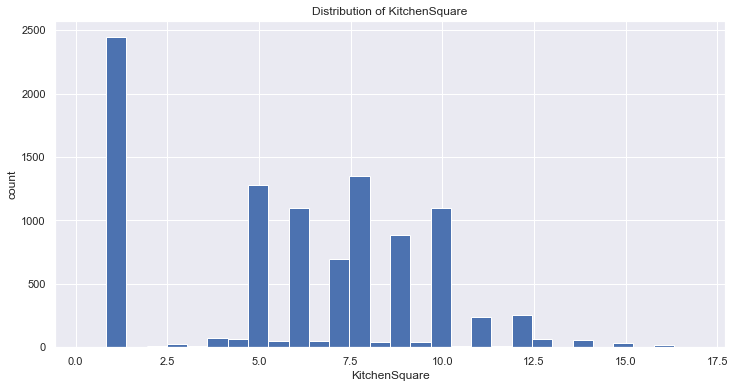

In [127]:
plt.figure(figsize = (12, 6))

train_df.loc[train_df['KitchenSquare'] < 17, 'KitchenSquare'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('KitchenSquare')

plt.title('Distribution of KitchenSquare')
plt.show()

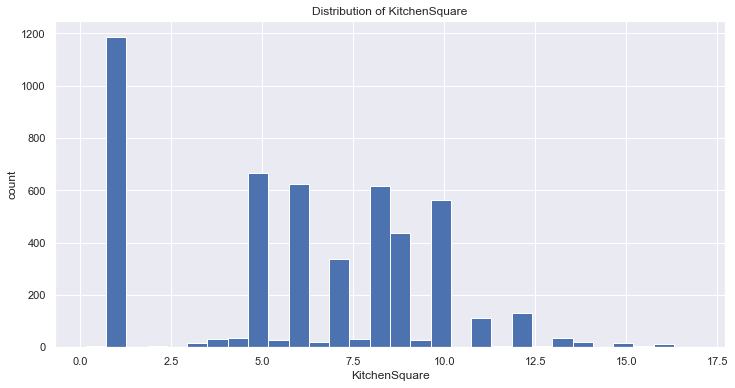

In [128]:
plt.figure(figsize = (12, 6))

test_df.loc[test_df['KitchenSquare'] < 17, 'KitchenSquare'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('KitchenSquare')

plt.title('Distribution of KitchenSquare')
plt.show()

In [129]:
train_df.loc[train_df['KitchenSquare'] <= 1, 'KitchenSquare'] = train_df['Square'] * median_k_sq_train
test_df.loc[test_df['KitchenSquare'] <= 1, 'KitchenSquare'] = test_df['Square'] * median_k_sq_test

Исправляем количество комнат у маленьких квартир

In [130]:
train_df.loc[(train_df['Square'] < 10) & (train_df['Rooms'] > 1), 'Rooms'] = 1
test_df.loc[(test_df['Square'] < 10) & (test_df['Rooms'] > 1), 'Rooms'] = 1

##### Очищаем данные по этажам

In [131]:
train_df.loc[(train_df['HouseFloor'] == 0) | (train_df['HouseFloor'] < train_df['Floor'])].shape

(1819, 19)

In [132]:
test_df.loc[(test_df['HouseFloor'] == 0) | (test_df['HouseFloor'] < test_df['Floor'])].shape

(884, 18)

Более 1800 некорректных значений в обучающем датасете и почти 900 в тестовом

Заполняем 0-е и более 98 значения этажности дома модой

In [133]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

train_df.loc[train_df['HouseFloor'] > 98, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
test_df.loc[test_df['HouseFloor'] > 98, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

Меняем значения этажей для строк, где этаж квартиры больше указанной этажности дома

In [134]:
floor_outliers_train = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers_test = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index

train_df.loc[floor_outliers_train, 'Floor'] = \
    train_df.loc[floor_outliers_train, 'HouseFloor'].apply(lambda x: random.randint(1, x))
test_df.loc[floor_outliers_test, 'Floor'] = \
    test_df.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

train_df.loc[train_df['Floor'] > train_df['HouseFloor']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,


#### Построение новых признаков

House_age_cat - категории домов по году постройки

In [135]:
def house_age_cat(X):

    X['House_age_cat'] = 0

    X.loc[2020 - X['HouseYear'] <= 5, 'House_age_cat'] = 1  
    X.loc[(2020 - X['HouseYear'] > 5) & (2020 - X['HouseYear'] <= 10), 'House_age_cat'] = 2
    X.loc[(2020 - X['HouseYear'] > 10) & (2020 - X['HouseYear'] <= 25), 'House_age_cat'] = 3
    X.loc[2020 - X['HouseYear'] > 25, 'House_age_cat'] = 4

    return X

In [136]:
train_df = house_age_cat(train_df)
test_df = house_age_cat(test_df)

Square_m_price - показатель стоимости 1 м^2 для отсева выбросов, перед обучением его удалим из датафрейма

In [137]:
train_df['Square_m_price'] = train_df['Price'] / train_df['Square']

Price_m_by_district - Стоимость метра квадратного жилья в зависимости от района

In [138]:
price_by_district = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'Square_m_price':'median'})\
                        .rename(columns={'Square_m_price':'Price_m_by_district'})

train_df = train_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)
test_df = test_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)

In [139]:
print(test_df['Price_m_by_district'].unique().shape, train_df['Price_m_by_district'].unique().shape)

(195,) (205,)


На тестовом датасете на 10 районов меньше, проверяем пропуски

In [140]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DistrictId           5000 non-null   int16  
 1   Rooms                5000 non-null   float32
 2   Square               5000 non-null   float32
 3   LifeSquare           5000 non-null   float32
 4   KitchenSquare        5000 non-null   float32
 5   Floor                5000 non-null   int64  
 6   HouseFloor           5000 non-null   float32
 7   HouseYear            5000 non-null   int16  
 8   Ecology_1            5000 non-null   float32
 9   Ecology_2            5000 non-null   int64  
 10  Ecology_3            5000 non-null   int64  
 11  Social_1             5000 non-null   int8   
 12  Social_2             5000 non-null   int16  
 13  Social_3             5000 non-null   float64
 14  Healthcare_1         5000 non-null   float32
 15  Helthcare_2          5000 non-null 

Убираем пропуски из тестового датасета

In [141]:
test_df.loc[(test_df['Price_m_by_district'].isna()), 'Price_m_by_district'] = test_df['Price_m_by_district'].median()

Удаляем квартиры со стоимостью более 9300 за м^2

In [142]:
train_df = train_df.drop(train_df[train_df['Square_m_price'] > 9300].index)

Room_square_m - добавляем показатель среднего метража комнат

In [143]:
train_df['Room_square_m'] = train_df['LifeSquare'] / train_df['Rooms']
test_df['Room_square_m'] = test_df['LifeSquare'] / test_df['Rooms']

Заполняем 0-е количество комнат значением жилой площади деленным на медианное значение прощади комнаты

In [144]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = round(train_df['LifeSquare'] / train_df['Room_square_m'].median())
test_df.loc[test_df['Rooms'] == 0, 'Rooms'] = round(test_df['LifeSquare'] / test_df['Room_square_m'].median())

Перезаполняем средний метраж комнат, значения которого = "inf"

In [145]:
train_df.loc[train_df['Room_square_m'] == float('inf'), 'Room_square_m'] = train_df['LifeSquare'] / train_df['Rooms']
test_df.loc[test_df['Room_square_m'] == float('inf'), 'Room_square_m'] = test_df['LifeSquare'] / test_df['Rooms']
test_df['Room_square_m'].max()

122.57893371582031

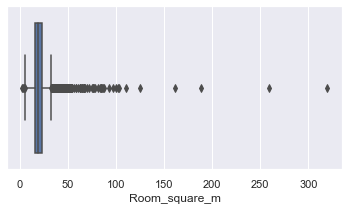

In [146]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Room_square_m'], whis=1.5)

plt.xlabel('Room_square_m')
plt.show()

Удаляем отклонения в среднем размере комнат

In [147]:
train_df = train_df.drop(train_df[train_df['Room_square_m'] > 124].index)

Floor_cat - Категория этажа квартиры

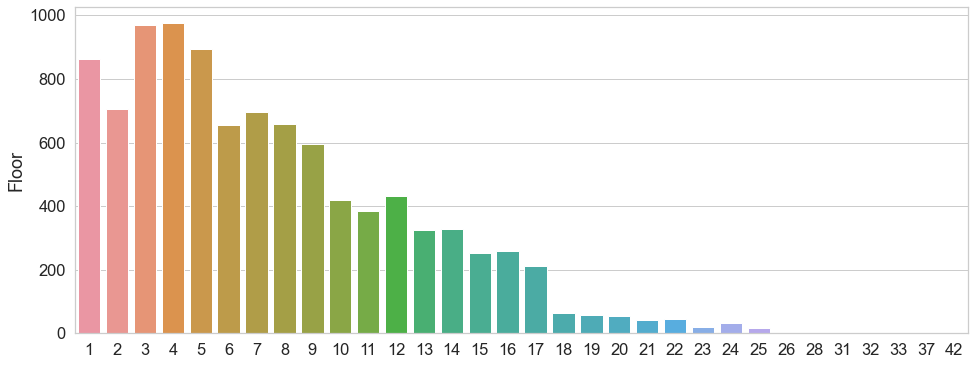

In [148]:
sns.set(style="whitegrid", font_scale=1.5)

f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y=train_df['Floor'].value_counts(), x=train_df['Floor'].value_counts().index);

In [149]:
train_df['Floor_cat'] = 0
train_df.loc[train_df['Floor'] <= 1, 'Floor_cat'] = 1
train_df.loc[(train_df['Floor'] == train_df['HouseFloor']) & (train_df['Square'] < 80), 'Floor_cat'] = 1  
train_df.loc[(train_df['Floor'] > 1) & (train_df['Floor'] <= 3), 'Floor_cat'] = 1
train_df.loc[(train_df['Floor'] > 3) & (train_df['Floor'] < train_df['HouseFloor']), 'Floor_cat'] = 2
train_df.loc[(train_df['Floor'] == train_df['HouseFloor']) & (train_df['Square'] > 80), 'Floor_cat'] = 3

test_df['Floor_cat'] = 0
test_df.loc[test_df['Floor'] <= 1, 'Floor_cat'] = 1
test_df.loc[(test_df['Floor'] == test_df['HouseFloor']) & (test_df['Square'] < 80), 'Floor_cat'] = 1
test_df.loc[(test_df['Floor'] > 1) & (test_df['Floor'] <= 3), 'Floor_cat'] = 1
test_df.loc[(test_df['Floor'] > 3) & (test_df['Floor'] < test_df['HouseFloor']), 'Floor_cat'] = 2
test_df.loc[(test_df['Floor'] == test_df['HouseFloor']) & (test_df['Square'] > 80), 'Floor_cat'] = 3

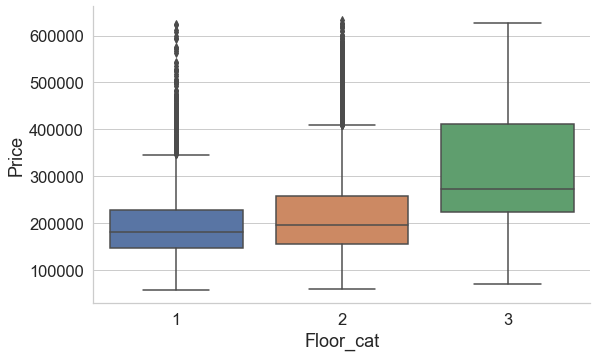

In [150]:
sns.catplot("Floor_cat", "Price", kind="box", data=train_df, aspect=5/3);

HouseFloor_cat - Категория этажности здания

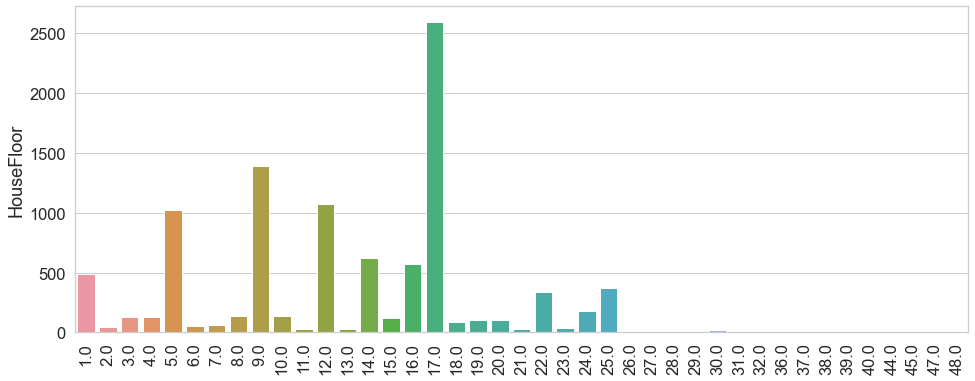

In [151]:
sns.set(style="whitegrid", font_scale=1.5)

f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y=train_df['HouseFloor'].value_counts(), 
            x=train_df['HouseFloor'].value_counts().index,
           )
ax.tick_params(axis='x', rotation=90);

In [152]:
train_df['HouseFloor_cat'] = 0
train_df.loc[train_df['HouseFloor'] <= 5, 'HouseFloor_cat'] = 1  
train_df.loc[(train_df['HouseFloor'] > 5) & (train_df['HouseFloor'] <= 12), 'HouseFloor_cat'] = 2
train_df.loc[(train_df['HouseFloor'] > 12) & (train_df['HouseFloor'] <= 17), 'HouseFloor_cat'] = 3
train_df.loc[train_df['HouseFloor'] > 17, 'HouseFloor_cat'] = 4

test_df['HouseFloor_cat'] = 0
test_df.loc[test_df['HouseFloor'] <= 5, 'HouseFloor_cat'] = 1  
test_df.loc[(test_df['HouseFloor'] > 5) & (test_df['HouseFloor'] <= 12), 'HouseFloor_cat'] = 2
test_df.loc[(test_df['HouseFloor'] > 12) & (test_df['HouseFloor'] <= 17), 'HouseFloor_cat'] = 3
test_df.loc[test_df['HouseFloor'] > 17, 'HouseFloor_cat'] = 4

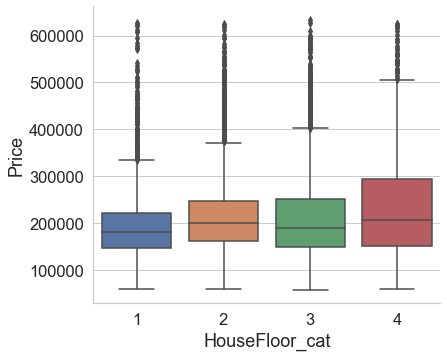

In [153]:
sns.catplot("HouseFloor_cat", "Price", kind="box", data=train_df, aspect=5/4);

In [154]:
train_df[['Floor_cat', 'HouseFloor_cat']] = train_df[['Floor_cat', 'HouseFloor_cat']].astype(int)
test_df[['Floor_cat', 'HouseFloor_cat']] = test_df[['Floor_cat', 'HouseFloor_cat']].astype(int)

Flat_kitchen_cat - Категория квартиры, в зависимости от площади ее кухни

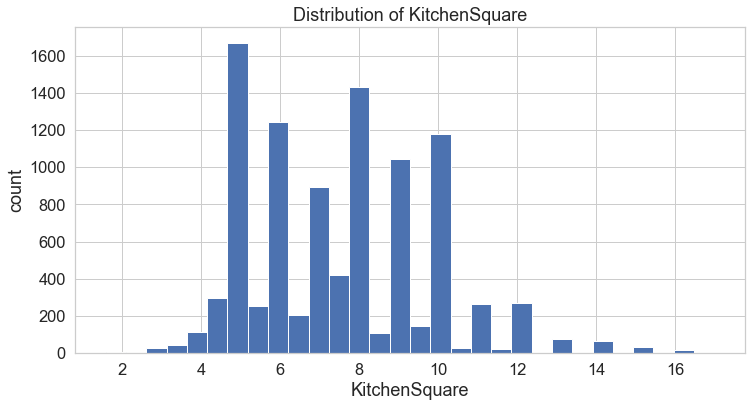

In [155]:
plt.figure(figsize = (12, 6))

train_df.loc[train_df['KitchenSquare'] < 17, 'KitchenSquare'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('KitchenSquare')

plt.title('Distribution of KitchenSquare')
plt.show()

In [156]:
train_df['Flat_kitchen_cat'] = 0
train_df.loc[train_df['KitchenSquare'] < 6, 'Flat_kitchen_cat'] = 1  
train_df.loc[(train_df['KitchenSquare'] >= 6) & (train_df['KitchenSquare'] < 8.5), 'Flat_kitchen_cat'] = 2
train_df.loc[(train_df['KitchenSquare'] >= 8.5) & (train_df['KitchenSquare'] < 11), 'Flat_kitchen_cat'] = 3
train_df.loc[train_df['KitchenSquare'] >= 11, 'Flat_kitchen_cat'] = 4

test_df['Flat_kitchen_cat'] = 0
test_df.loc[test_df['KitchenSquare'] < 6, 'Flat_kitchen_cat'] = 1  
test_df.loc[(test_df['KitchenSquare'] >=6 ) & (test_df['KitchenSquare'] < 8.5), 'Flat_kitchen_cat'] = 2
test_df.loc[(test_df['KitchenSquare'] >= 8.5) & (test_df['KitchenSquare'] < 11), 'Flat_kitchen_cat'] = 3
test_df.loc[test_df['KitchenSquare'] >= 11, 'Flat_kitchen_cat'] = 4

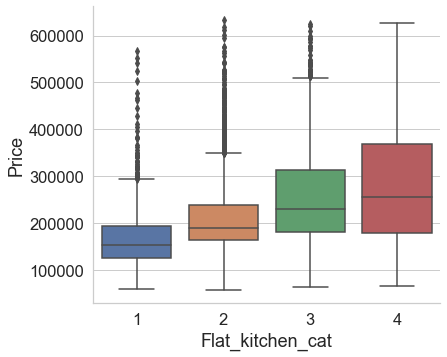

In [157]:
sns.catplot("Flat_kitchen_cat", "Price", kind="box", data=train_df, aspect=5/4);

Price_square_m_floor_cat - Цена м^2 жилья по району в зависимости от категории этажа

In [158]:
price_square_m_floor_cat  = train_df.groupby(['DistrictId', 'Floor_cat'])\
                        .agg({'Square_m_price':'median'})\
                        .rename(columns={'Square_m_price':'Price_square_m_floor_cat'})

train_df = train_df.merge(price_square_m_floor_cat, on=['DistrictId', 'Floor_cat'], how='left').set_index(train_df.index)
test_df = test_df.merge(price_square_m_floor_cat, on=['DistrictId', 'Floor_cat'], how='left').set_index(test_df.index)

In [159]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DistrictId                5000 non-null   int16  
 1   Rooms                     5000 non-null   float32
 2   Square                    5000 non-null   float32
 3   LifeSquare                5000 non-null   float32
 4   KitchenSquare             5000 non-null   float32
 5   Floor                     5000 non-null   int64  
 6   HouseFloor                5000 non-null   float32
 7   HouseYear                 5000 non-null   int16  
 8   Ecology_1                 5000 non-null   float32
 9   Ecology_2                 5000 non-null   int64  
 10  Ecology_3                 5000 non-null   int64  
 11  Social_1                  5000 non-null   int8   
 12  Social_2                  5000 non-null   int16  
 13  Social_3                  5000 non-null   float64
 14  Healt

Убираем пропуски из тестового датасета

In [160]:
test_df.loc[(test_df['Price_square_m_floor_cat'].isna()), 'Price_square_m_floor_cat'] = test_df['Price_m_by_district']

#### Строим матрицу корреляций

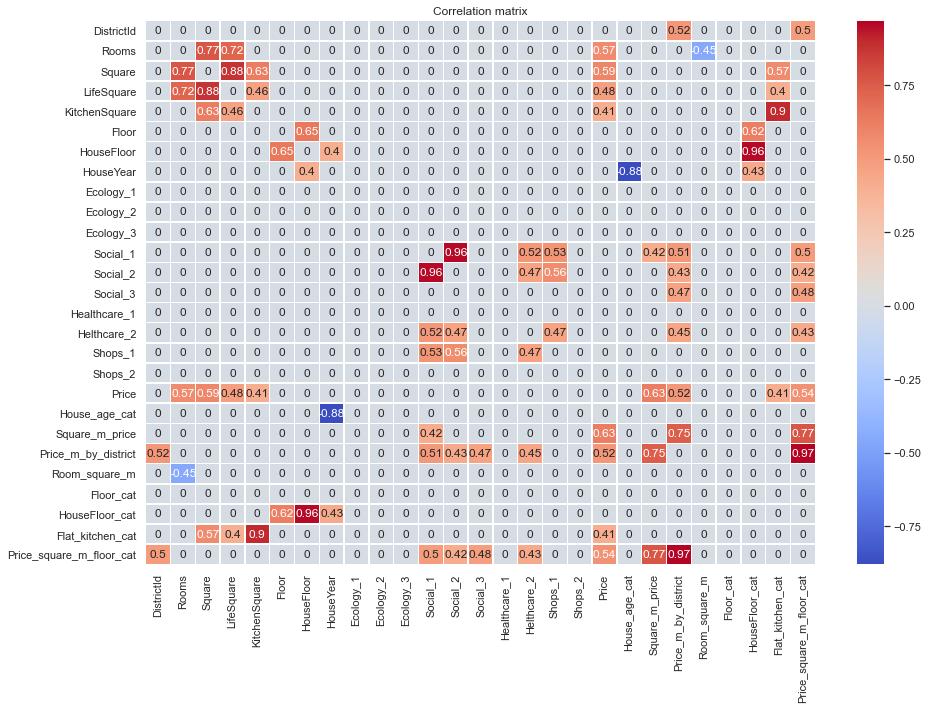

In [161]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[(np.abs(corr_matrix) < 0.4) | (np.abs(corr_matrix) == 1)] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### Отбор признаков и подготовка модели

In [162]:
list(train_df)

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'House_age_cat',
 'Square_m_price',
 'Price_m_by_district',
 'Room_square_m',
 'Floor_cat',
 'HouseFloor_cat',
 'Flat_kitchen_cat',
 'Price_square_m_floor_cat']

In [163]:
target_name = ['Price']
feature_names = ['DistrictId',
 'Rooms',
 'Square',
 #'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 #'Ecology_3',
 'Social_1',
 #'Social_2',
 #'Social_3',
 #'Healthcare_1',
 #'Helthcare_2',
 'Shops_1',
 #'Shops_2',
 #'Price',
 'House_age_cat',
 #'Square_m_price',
 'Price_m_by_district',
 'Room_square_m',
 'Floor_cat',
 #'HouseFloor_cat',
 #'Flat_kitchen_cat',
 'Price_square_m_floor_cat']

In [164]:
X = train_df[feature_names]
y = train_df[target_name]

X.head()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Social_1,Shops_1,House_age_cat,Price_m_by_district,Room_square_m,Floor_cat,Price_square_m_floor_cat
Id,,,,,,,,,,,,,,,,
14038,35,2.0,47.981560,6.000000,7,9.0,1969,0.089040,1,33,11,4,4358.274902,14.721375,2,4541.385742
15053,41,3.0,65.683640,8.000000,7,9.0,1978,0.000070,1,46,16,4,4437.304199,13.349847,2,4473.328125
4765,53,2.0,44.947952,5.135607,8,12.0,1968,0.049637,1,34,3,4,4845.918945,14.598805,2,4820.189941
5809,58,2.0,53.352982,9.000000,8,17.0,1977,0.437885,1,23,5,4,2949.975342,26.365755,2,3154.331787
10783,99,1.0,39.649193,7.000000,11,12.0,1976,0.012339,1,35,4,4,3992.031250,23.776169,2,4126.694336


### Метод Random Forest Regressor

Данный метод, как ни странно, дал лучшие показатели, чем GradientBoostingRegressor, BaggingRegressor, VotingRegressor, StackingRegressor и CatBoosterRegressor

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42)

In [166]:
model = RandomForestRegressor(n_estimators=350, max_depth=16, random_state=42, n_jobs=-1, max_features='log2')

model.fit(X_train, y_train.values[:, 0])

y_pred_1 = model.predict(X_test)

r2_1 = r2_score(y_test, y_pred_1)
r2_1

0.7764137029797952

Важность признаков

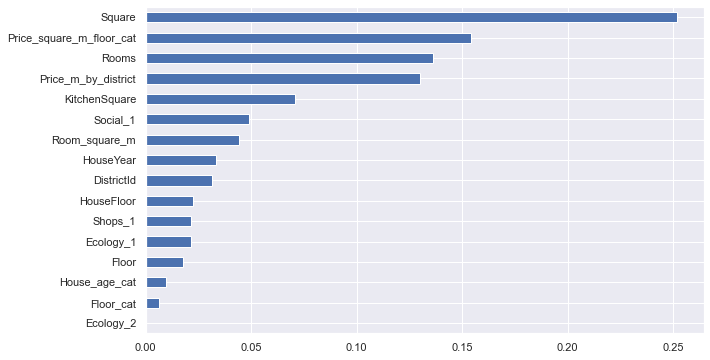

In [167]:
model.fit(X, y)
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values(ascending=True, inplace=True)

feat_importances.plot(kind='barh', figsize=(10, 6));

### Настройка и оценка финальной модели

In [168]:
%%script false
%%time
params = {'n_estimators':[100, 350, 450, 500, 650, 800, 1200], 
          'max_depth':[7, 12, 16, 20, 22, 26],
         'max_features': ['auto', 'sqrt', 'log2']}

gs = GridSearchCV(model, params, 
                  scoring='r2', 
                  cv=KFold(n_splits=5,
                           random_state=42, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

Wall time: 9min 46s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(max_depth=16, max_features='log2',
                                             n_estimators=350, n_jobs=-1,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [7, 12, 16, 20, 22, 26],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 350, 450, 500, 650, 800, 1200]},
             scoring='r2')

In [169]:
gs.best_params_

{'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 1200}

In [170]:
n_est = gs.best_params_['n_estimators']
max_d = gs.best_params_['max_depth']
max_f = gs.best_params_['max_features']
n_est, max_d, max_f

(1200, 12, 'sqrt')

Переобучаем модель по новым расчитаным параметрам

In [171]:
model_2 = RandomForestRegressor(n_estimators=n_est, max_depth=max_d, random_state=42, max_features=max_f)

In [172]:
model_2.fit(X_train, y_train.values[:, 0])

RandomForestRegressor(max_depth=12, max_features='sqrt', n_estimators=1200,
                      random_state=42)

In [173]:
y_pred_2 = model_2.predict(X_test)

In [174]:
r2_2 = r2_score(y_test, y_pred_2)
r2_2

0.7775645615979075

Обучение модели на всем тренировочном датасете

In [175]:
model_final = model_2

model_final.fit(X, y.values[:, 0])

RandomForestRegressor(max_depth=12, max_features='sqrt', n_estimators=1200,
                      random_state=42)

### Прогнозирование на тестовом датасете

In [176]:
X_test = test_df[feature_names]

y_pred = model_final.predict(X_test)

preds = pd.DataFrame()
preds['Id'] = X_test.index
preds['Price'] = y_pred

In [177]:
preds.to_csv('submission.csv', index=False)